# Tribolium embryo morphometry over time in Napari
Authors: Robert Haase, Daniela Vorkel, 2020

This is the pyclesperanto version of a workflow earlier [published for clij2](https://clij.github.io/clij2-docs/md/tribolium_morphometry/). 
[ImageJ Macro original](https://github.com/clij/clij2-docs/tree/master/src/main/macro/tribolium_morphometry.ijm)

This script is an example of heavy GPU-accelerated processing. It is recommended to use a dedicated
graphics card with at least 8 GB of GDDR6 memory. Otherwise, it may be quite slow.

Let's start by checking that pyclesperanto is installed and which GPU it uses.

In [1]:
import pyclesperanto_prototype as cle
import numpy as np

cle.select_device("RTX")

<Apple M1 Max on Platform: Apple (2 refs)>

## Load a data set
The dataset shows a *Tribolium castaneum* embryo, imaged by a custom light sheet microscope, at a wavelength of 488nm (Imaging credits: Daniela Vorkel, Myers lab, MPI CBG). It can be [downloaded from zenodo](https://zenodo.org/record/4276076#.YeLW8ljMJ_N).
The data set has been resampled to a voxel size of 1x1x1 microns. The embryo expresses nuclei-GFP. We will use the dataset to detect nuclei and to generate an estimated cell-segmentation.

All processing steps are performed in 3D space.

In [2]:
from skimage.io import imread

timelapse = imread('/Users/haase/data/Lund_18.0_22.0_Hours-resampled.tif')

# print out the spatial dimensions of the image
print(timelapse.shape)

(25, 140, 532, 266)


In [3]:
def process_image(image):
    import time

    start_time = time.time()
    
    # push image to GPU memory and show it
    gpu_input = cle.push(image)
    # print(gpu_input)
    
    # gaussian blur
    sigma = 2.0
    gpu_blurred = cle.gaussian_blur(gpu_input, sigma_x=sigma, sigma_y=sigma, sigma_z=sigma)

    # detect maxima
    gpu_detected_maxima = cle.detect_maxima_box(gpu_blurred)
    
    # threshold
    threshold = 300.0
    gpu_thresholded = cle.greater_constant(gpu_blurred, constant=threshold)

    # mask
    gpu_masked_spots = cle.mask(gpu_detected_maxima, gpu_thresholded)

    # label spots
    gpu_labelled_spots = cle.connected_components_labeling_box(gpu_masked_spots)
    # show_labels(gpu_labelled_spots)
    
    number_of_spots = int(cle.maximum_of_all_pixels(gpu_labelled_spots))
    # print("Number of detected spots: " + str(number_of_spots))
    
    # label map closing
    number_of_dilations = 10
    flip = cle.create_labels_like(gpu_labelled_spots)
    flop = cle.create_labels_like(gpu_labelled_spots)
    flag = cle.create([1,1,1])
    cle.copy(gpu_labelled_spots, flip)

    for i in range (0, number_of_dilations) :
        cle.onlyzero_overwrite_maximum_box(flip, flag, flop)
        cle.onlyzero_overwrite_maximum_diamond(flop, flag, flip)

    # erode labels
    flap = cle.greater_constant(flip, constant=1)
    number_of_erosions = 4
    for i in range(0, number_of_erosions):
        cle.erode_box(flap, flop)
        cle.erode_box(flop, flap)

    gpu_labels = cle.mask(flip, flap)
    
    # get result back from GPU as numpy array
    result = cle.pull(gpu_labels).astype(np.uint16)
        
    print("Processing took " + str(time.time() - start_time) + " s")

    return result

In [4]:
from skimage import data
import napari
viewer = napari.Viewer()

If you want to compute separable approximations, please install it with
pip install scikit-tensor-py3


In [5]:
# voxel size z,y,x
calibration = [1, 1, 1]

# convenience function for visualisation
def show(image):
    viewer.add_image(image, scale=calibration)
    
def show_labels(labels):
    viewer.add_labels(labels, scale=calibration)

In [6]:
# adapted from: https://github.com/tlambert03/napari-dask-example/blob/master/dask_napari.ipynb
import dask
import dask.array as da

# create dask stack of lazy image readers
lazy_process_image = dask.delayed(process_image)  # lazy reader
lazy_arrays = [lazy_process_image(timelapse[n]) for n in range(0, timelapse.shape[0])]
dask_arrays = [
    da.from_delayed(lazy_array, shape=timelapse[0].shape, dtype=np.uint16)
    for lazy_array in lazy_arrays
]
# Stack into one large dask.array
dask_stack = da.stack(dask_arrays, axis=0)
dask_stack

dask.array<stack, shape=(25, 140, 532, 266), dtype=uint16, chunksize=(1, 140, 532, 266), chunktype=numpy.ndarray>

In [7]:
print(timelapse.shape[0])

25


In [8]:
show(timelapse)
show_labels(dask_stack)

Processing took 0.3502938747406006 s
Processing took 0.268435001373291 s
Processing took 0.2793867588043213 s


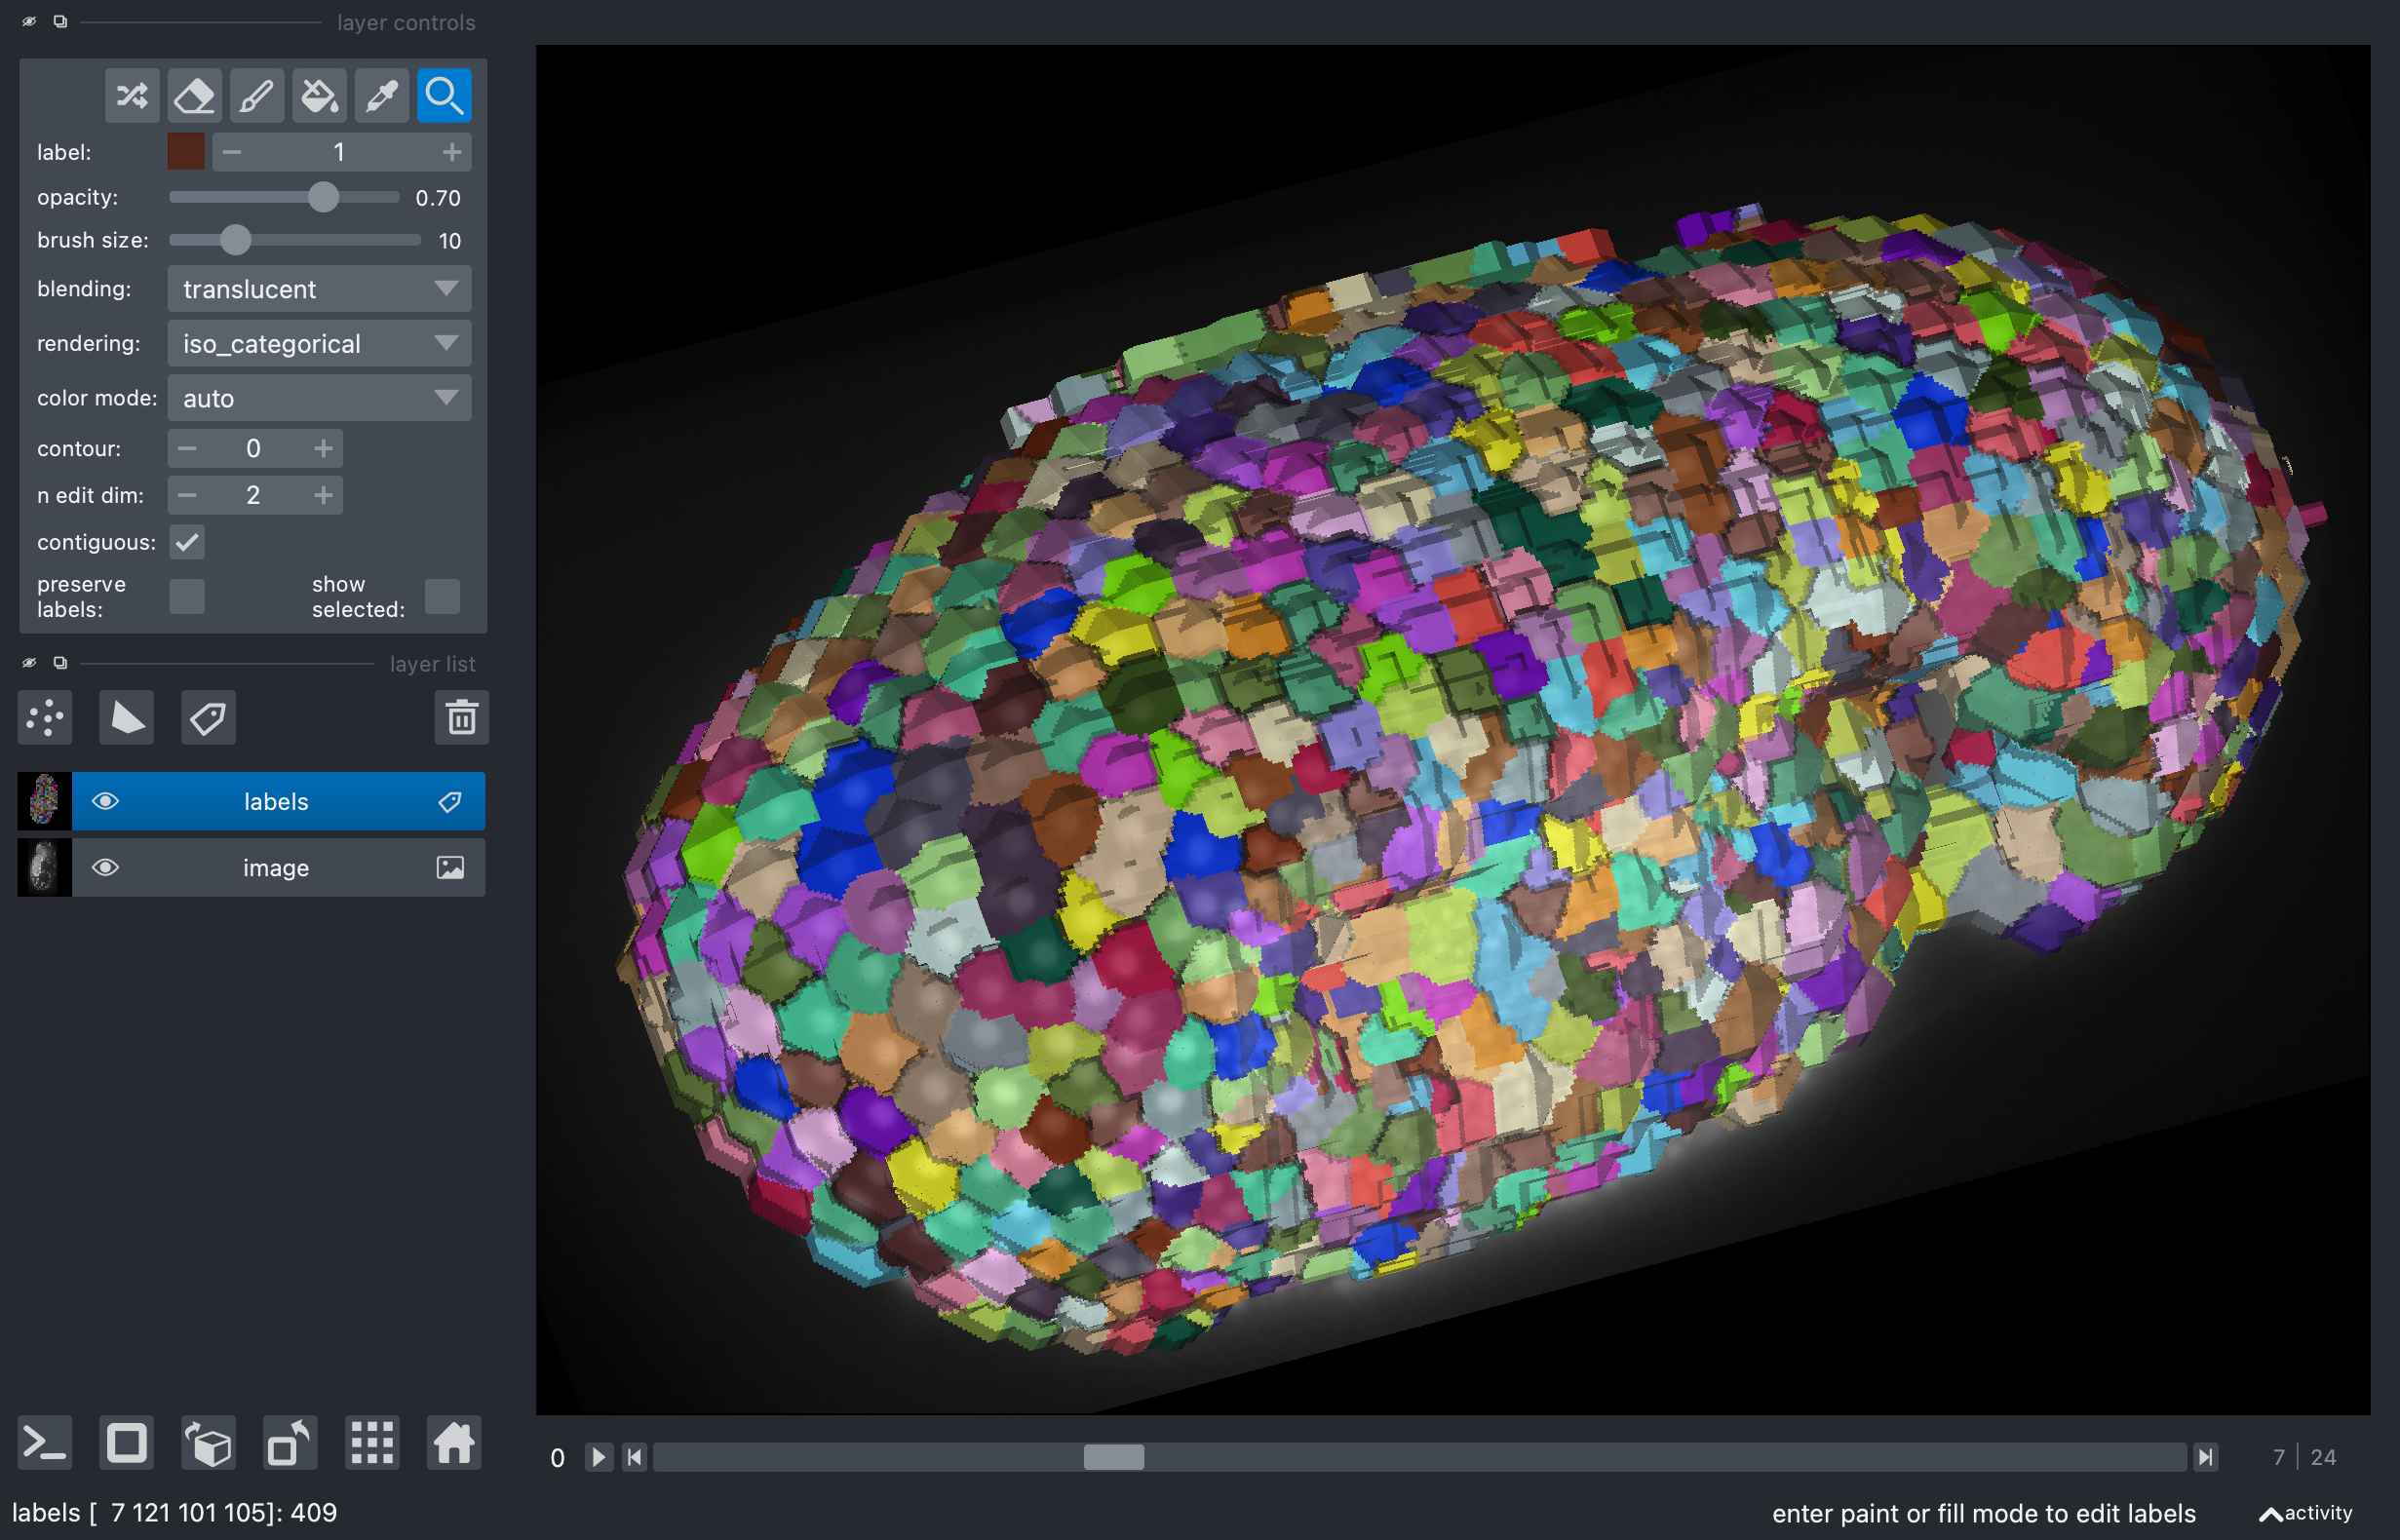

In [9]:
from napari.utils import nbscreenshot
nbscreenshot(viewer)